In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.gridspec import GridSpec

In [2]:
plt.rcParams.update({"font.family": "Roboto Condensed"})

https://github.com/mcsiple/tidytuesday/blob/master/2021/5_2021_plastics.R

https://raw.githubusercontent.com/mcsiple/tidytuesday/master/2021/5_2021_plastics.png

https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-01-26/readme.md

In [3]:
path = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-26/plastics.csv"
data = pd.read_csv(path)

In [4]:
types_of_plastic = ["empty", "hdpe", "ldpe", "o", "pet", "pp", "ps", "pvc"]
total_by_company = (
    data
    .groupby(["parent_company", "year"], dropna=True)[types_of_plastic]
    .sum()
    .reset_index()
)
total_by_company

,parent_company,year,empty,hdpe,ldpe,o,pet,pp,ps,pvc
0,"""ESE""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Inko"" noodles / Ð®Ñ„ÐºÐ° â€œÐ˜Ð½ÐºÐ¾""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""Мелочи Жизни"" (Ооо Ергопак)",2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,#ERROR!,2020,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
4,(Local Factory),2020,0.0,0.0,0.0,0.0,9.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11215,Ямуна,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
11216,Янтар,2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11217,Янтар (Сан Інбев Україна),2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11218,Янтарь,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
def get_top_n_data(data, n):
    """Create data frame with plastic values for the top-n companies and one Others group."""

    # Analyses data from 2020 only
    # Compute the total plastic waste per company
    top_data = (
        data
        .query("year == 2020")
        .melt(
            id_vars=["parent_company", "year"], 
            value_vars=types_of_plastic, 
            var_name="type"
        )
        .groupby("parent_company")["value"]
        .sum()
        .reset_index()
    )

    # Use "Unbranded_unknown" for unbranded/unknown/error cases
    top_data["parent_company"] = np.where(
        top_data["parent_company"].isin(["Unbranded", "null", "NULL", "#ERROR!"]), 
        "Unbranded_unknown",
        top_data["parent_company"]
    )

    # Create a list of top companies.
    # This list contains the top n companies with largest plastic waste.
    top_companies = list(top_data.sort_values("value", ascending=False)["parent_company"][:n])

    # Create a lumped version of the company variable. 
    # If "parent_company" is one of the top companies, it gets its original name. 
    # Otherwise, it's labelled with "Other"
    top_data["company_lumped"] = np.where(
        top_data["parent_company"].isin(top_companies),
        top_data["parent_company"],
        "Other"
    )

    # Merge `top_data` with `total_by_company`
    top_data = top_data.drop_duplicates(["parent_company", "company_lumped"])
    top_data = top_data.merge(total_by_company, on="parent_company")

    # Sum all types of plastic except from 'empty' into the "total" variable
    top_data["total"] = top_data.loc[:, types_of_plastic[1:]].sum(axis=1)

    return top_data

## Heatmap

In [6]:
top_thirty = get_top_n_data(total_by_company, n=30)

# For each company, compute the total waste per each type of plastic
top_thirty = (
    top_thirty
    .groupby("company_lumped")[types_of_plastic]
    .sum()
    .reset_index()
)

# Add a column with the sum of the plastic waste for all types of plastic
top_thirty["row_sum"] = top_thirty.loc[:, types_of_plastic].sum(axis=1)

# Divide the waste of each type of plastic by the total waste to get the proportion of waste for
# each type of plastic
top_thirty[types_of_plastic] = top_thirty[types_of_plastic].apply(lambda x: x / top_thirty["row_sum"])

# Unpivot data
top_thirty = top_thirty.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="proportion"
)

top_thirty

,company_lumped,type,proportion
0,Bakhresa Group,empty,0.000000
1,Blow-Chem Industries,empty,0.000000
2,Britannia,empty,0.000000
3,Colgate-Palmolive,empty,0.000611
4,Cway Group,empty,0.000000
...,...,...,...
235,Unilever,pvc,0.002212
236,Universal Robina Corporation,pvc,0.005780
237,Voltic Ghana Limited,pvc,0.000000
238,W.L. Food Products,pvc,0.000000


Let's make sure company names are sorted appropriately. Company names are sorted alphabetically, except from `"Others"` which goes in the last place.

In [7]:
# Get company names
categories = list(top_thirty["company_lumped"].unique())
# Sort categories according to their lowercase version (this step is important!)
sorted_categories = sorted(categories, key=str.lower)
# Remove "Other" from the list and append it to the taiL
sorted_categories.remove("Other")
sorted_categories.append("Other")

Now use these categories to convert the `"company_lumped"` variable into an ordered categorical variable.

In [8]:
top_thirty["company_lumped"] = pd.Categorical(
    top_thirty["company_lumped"], 
    categories=sorted_categories, 
    ordered=True
)

# Finally, sort the values in the data frame according to this custom sort.
top_thirty = top_thirty.sort_values("company_lumped", ascending=False)

Let's create the colormap for the heatmap. These colors are obtained from the `"YlGnBu"` palette in the `RColorBrewer` package in [R](https://www.r-graph-gallery.com/).

In [9]:
# Define colors
COLORS = ["#0C2C84", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)

In [10]:
def plot_heatmap(ax):
    # Iterate over types of plastic
    for i, plastic in enumerate(types_of_plastic):
        # Select data for the given type of plastic
        d = top_thirty[top_thirty["type"] == plastic]

        # Get values for the x and y axes
        y = d["company_lumped"]
        x = [i] * len(y)
        
        # Generate colors. No need to normalize since proportions are between 0 and 1.
        color = cmap(d["proportion"]) 
        
        # Plot the markers for the selected company
        ax.scatter(x, y, color=color, s=120)

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(types_of_plastic)))

    # Set labels for the x ticks (the names of the types of plastic)
    ax.set_xticklabels(types_of_plastic)

    # Remove tick marks by setting their size to 0
    ax.tick_params(size=0)

    # Set label for horizontal axis.
    ax.set_xlabel("Type of plastic", loc="right")

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)
    
    return ax

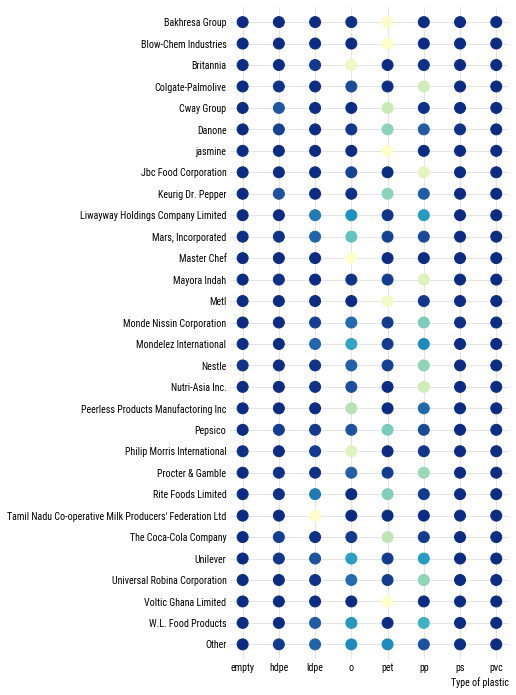

In [11]:
fig, ax = plt.subplots(figsize=(5, 12))
plot_heatmap(ax);

## Circular barplots

This chart uses its own palette:

In [12]:
# Top 6 companies palettes, from design-seeds.com
COMPANY_PALETTES = ["#81C4CA", "#468D96", "#103128", "#E83D5F", "#FA6E90", "#FCB16D"]

It is also needed to do some data processing here:

In [13]:
top_seven = get_top_n_data(total_by_company, n=7)

# Unpivot data
top_seven = top_seven.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="amount"
)

# Drop entries where company is unbranded/unknown or other
top_seven = top_seven[~top_seven["company_lumped"].isin(["Unbranded_unknown", "Other"])]

# Drop entries where plastyic type is either "ps", "pvc", or "empty"
top_seven = top_seven[~top_seven["type"].isin(["ps", "pvc", "empty"])]

# For each company and type of plastic, compute the sum of plastic waste
top_seven = top_seven.groupby(["company_lumped", "type"]).sum().reset_index()

# Rename "amount" to "total"
top_seven = top_seven.rename({"amount": "total"}, axis=1)

# Compute the proportion of plastic waste for each type within each company
top_seven["prop"] = top_seven["total"] / top_seven.groupby("company_lumped")["total"].transform("sum")

And now, let's start creating functions for our chart! First, we have this auxiliary function that
takes a circular axis object and applies some styles and customizations:

In [14]:
def style_polar_axis(ax):
    # Change the initial location of the 0 in radians
    ax.set_theta_offset(np.pi / 2)
    
    # Move in clock-wise direction 
    ax.set_theta_direction(-1)

    # Remove all spines
    ax.set_frame_on(False)

    # Don't use tick labels for radial axis
    ax.set_xticklabels([])
    
    # Set limits for y axis
    ax.set_ylim([0, 4.5])
    # Set ticks for y axis. These determine the grid lines.
    ax.set_yticks([0, 1, 2, 3, 4, 4.5])
    # But don't use tick labels
    ax.set_yticklabels([])
    
    # Set grid with some transparency
    ax.grid(alpha=0.4)

    return ax

Then, there's the following function that takes an axis and a color, and adds the labels corresponding to each line in each circular plot.

In [15]:
def add_labels_polar_axis(ax, color):
    # Define the characteristics of the bbox behind the text we add
    bbox_dict = {
        "facecolor": "w", "edgecolor": color, "linewidth": 1, 
        "boxstyle": "round", "pad": 0.15
    }
    types_of_plastic = ["hdpe", "ldpe", "o", "pet", "pp"]
    # Iterate over types of plastics and add the labels
    for idx, plastic in enumerate(types_of_plastic):
        ax.text(
            0, idx, plastic, color=color, ha="center", va="center",
            fontsize=11, bbox=bbox_dict
        )
    return ax

Finally, the function we use directly, the one that creates the chart itself:

In [16]:
def plot_circular(axes):
    axes_flattened = axes.ravel()
    companies = top_seven["company_lumped"].unique()
    
    # Iterate over companies and plots
    for i, company in enumerate(companies):
        # Select data for the given company
        d = top_seven[top_seven["company_lumped"] == company]
        
        # Select plot
        ax = axes_flattened[i]
        
        # Only for the first panel, add label for vertical axis
        if i == 0:
            ax.set_ylabel("Type of plastic", loc="top")
        
        # Adjust style of the plot
        ax = style_polar_axis(ax)
        
        # Multiply the proportion by the 2pi, the complete rotation 
        proportions = d["prop"].values * (2 * np.pi)
        
        # Positions for the lines on the radial
        y_pos = np.arange(len(proportions))
        
        # Construct the line for each type of plastic creating a grid for the x and y values
        x = np.linspace(0, proportions, num=200)
        y = np.vstack([y_pos] * 200)

        # Select color
        color = COMPANY_PALETTES[i]
        
        # And finally, plot the rounded lines
        ax.plot(x, y, lw=6, color=color, solid_capstyle="round")
        
        # Add title
        ax.set_title(company, pad=10, color="0.3")
        
        # Add labels on top of the lines
        ax = add_labels_polar_axis(ax, color)
    return axes

Let's see how it looks like!

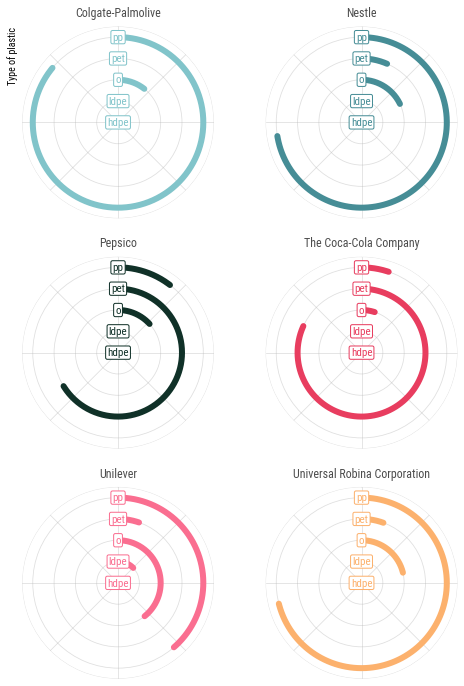

In [17]:
# Initialize layout
fig, axes = plt.subplots(3, 2, figsize=(8, 12), subplot_kw={"projection": "polar"})

# Create chart! 
axes = plot_circular(axes)

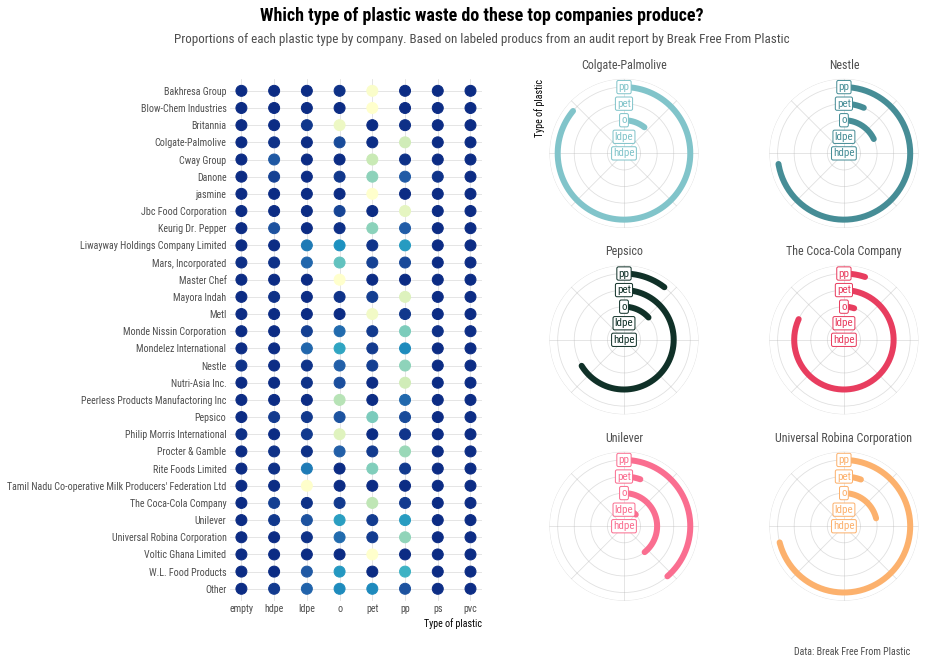

In [18]:
fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 1, left=0.25, right=0.5, top=0.85)
ax = fig.add_subplot(gs1[0])

axes = []
gs2 = GridSpec(3, 2, left=0.55, right=0.95, hspace=0.25, top=0.85)
for gs in gs2:
    axes.append(fig.add_subplot(gs, projection="polar"))

axes = np.array(axes)
plot_heatmap(ax)
ax.tick_params(axis="both", colors="0.3")
plot_circular(axes)

fig.text(
    0.5, 0.93, "Which type of plastic waste do these top companies produce?",
    ha="center", va="baseline", size=18, weight="bold"
)
fig.text(
    0.5, 0.9, 
    "Proportions of each plastic type by company. Based on labeled producs from an audit report by Break Free From Plastic",
    ha="center", va="baseline", size=13, color="0.3"
)

fig.text(0.925, 0.05, "Data: Break Free From Plastic", color="0.3", ha="right")
fig.set_facecolor("w")
fig.savefig("plot.png", dpi=300)

---
For the extra mile section:

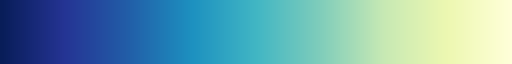

In [19]:
cmap = plt.get_cmap("YlGnBu")
cmap = cmap.reversed()
cmap

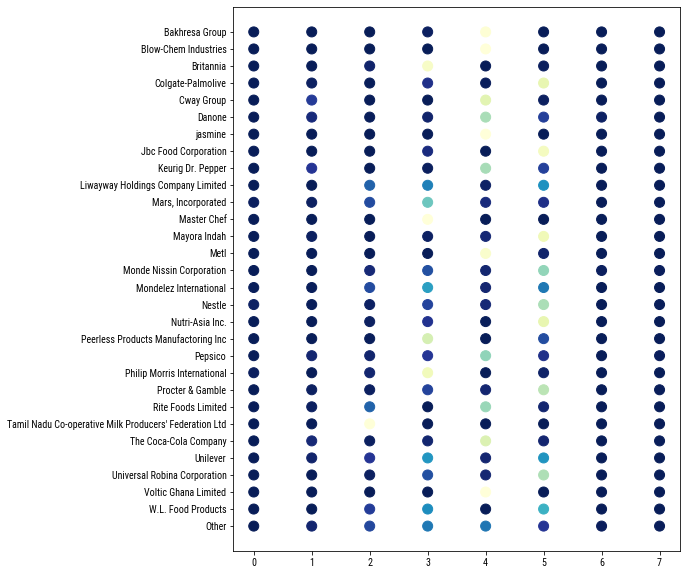

In [20]:
fig, ax = plt.subplots(figsize = (8, 10))

for i, plastic in enumerate(types_of_plastic):
    d = top_thirty[top_thirty["type"] == plastic]
    y = d["company_lumped"]

    # No need to normalize since proportions are between 0 and 1
    colors = cmap(d["proportion"])

    ax.scatter([i] * len(y), d["company_lumped"], color=colors, s=100)